# Modelagem Preditiva

## Introdução
Neste notebook, vamos desenvolver um modelo preditivo para identificar entregas problemáticas ou possíveis fraudes no sistema de entregas do Walmart. Com base nos dados integrados e analisados nos notebooks anteriores, este modelo será treinado para prever se um pedido terá itens faltantes, permitindo uma identificação proativa de problemas e ajudando a mitigar fraudes ou falhas no processo de entrega.


## Objetivo do Modelo Preditivo
O objetivo principal é criar um modelo que seja capaz de prever fraudes ou problemas nas entregas com base nos dados disponíveis. Isso envolve:
1. Identificar entregas problemáticas com alta precisão e recall, permitindo ações preventivas.
2. Reduzir custos associados a entregas problemáticas, como reembolsos e auditorias manuais.
3. Melhorar a eficiência logística ao priorizar pedidos com maior probabilidade de problemas.
## Etapas
* **Preparação dos Dados**
	1. Carregar e revisar o dataset integrado `df_final`.
    2. Selecionar as variáveis relevantes.
    3. Dividir os dados em conjuntos de treinamento e teste.
*  **Criação da Variável-Alvo (`fraud_flag`):** 
   - A variável-alvo foi criada para identificar entregas problemáticas:
     - `1` para pedidos com problemas (ex.: itens faltantes).
     - `0` para pedidos sem problemas.
* **Feature Engineering:**
   - Criar novas variáveis relevantes para o modelo, incluindo:
     - Taxa de reclamação do motorista.
     - Taxa de reclamação do cliente.
     - Valor total do pedido.
     - Recorrência de motoristas e clientes.
     - Período da entrega (manhã/tarde/noite).
* **Seleção de Features Relevantes:**
   - As features mais relevantes foram selecionadas com base na análise exploratória:
     - `order_amount`, `region`, `items_delivered`, `delivery_period`, 
       `day_of_week`, `driver_age_group`, `Trips`, `customer_age_group`,
       `driver_complaint_rate`, `customer_complaint_rate`, 
       `is_night_delivery`, `order_value_category`.
* **Pré-Processamento dos Dados:**
   - Codificação de variáveis categóricas usando `pd.get_dummies`.
   - Normalização das variáveis numéricas para garantir escalas consistentes.
* **Divisão dos Dados em Treino e Teste:**
   - Os dados foram divididos em:
     - Treino: 70% (7000 amostras).
     - Teste: 30% (3000 amostras).
* **Treinamento dos Modelos:**
   - Modelos treinados:
     1. Logistic Regression
     2. Random Forest
     3. XGBoost
     4. Decision Tree
     5. Gradient Boosting Classifier
* **Avaliação dos Modelos:**
    - As métricas avaliadas incluem:
      - Recall, Precision, F1-Score (Classe Fraude).
      - ROC-AUC.
      - Balanced Accuracy.
    - Curvas ROC-AUC foram geradas para cada modelo.
    - Matrizes de confusão foram plotadas para entender os erros do modelo.
* **Comparação dos Modelos:**
    - Os resultados foram organizados em um DataFrame comparativo para facilitar a análise.
    - Identificar possíveis melhorias no processo de entrega com base nos resultados do modelo.
  
Ao final deste notebook, esperamos obter um modelo robusto que possa ser utilizado para prever entregas problemáticas e fornecer insights valiosos para melhorar os processos logísticos e reduzir fraudes no sistema de entregas do Walmart.


### Importar Bibliotecas Necessárias

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import joblib


### Carregar e revisar o dataset integrado `df_final`
* Carregue o dataset integrado (`df_final`) criado no segundo notebook (Integração dos Datasets)

In [2]:
# Carregar o dataset integrado
df_final = pd.read_csv('df_final.csv')


# Verificar informações gerais do dataset
print(df_final.info())

# Verificar as primeiras linhas do dataset

df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     10000 non-null  object 
 1   order_id                 10000 non-null  object 
 2   order_amount             10000 non-null  float64
 3   region                   10000 non-null  object 
 4   items_delivered          10000 non-null  int64  
 5   items_missing            10000 non-null  int64  
 6   delivery_hour            10000 non-null  object 
 7   driver_id                10000 non-null  object 
 8   customer_id              10000 non-null  object 
 9   missing_rate             10000 non-null  float64
 10  month_name               10000 non-null  object 
 11  items_range              10000 non-null  object 
 12  customer_name            10000 non-null  object 
 13  customer_age             10000 non-null  int64  
 14  customer_age_group     

,date,order_id,order_amount,region,items_delivered,items_missing,delivery_hour,driver_id,customer_id,missing_rate,...,price,delivery_period,day_of_week,fraud_flag,driver_complaint_rate,is_night_delivery,customer_complaint_rate,order_value_category,driver_recurrence,customer_recurrence
0,2023-01-01,c9da15aa-be24-4871-92a3-dfa7746fff69,1095.54,Winter Park,10,1,08:37:28,WDID10627,WCID5031,0.100000,...,[],Manhã,Sunday,1,0.272727,False,0.500000,high,11,2
1,2023-01-01,ccacc183-09f8-4fd5-af35-009d18656326,659.11,Altamonte Springs,11,1,09:31:17,WDID10533,WCID5794,0.090909,...,[],Manhã,Sunday,1,0.363636,False,0.142857,high,11,7
2,2023-01-01,f4e1d30b-c3d1-413f-99b8-93c0b46d68bf,251.45,Winter Park,18,1,10:43:49,WDID10559,WCID5599,0.055556,...,[],Manhã,Sunday,1,0.272727,False,0.153846,high,11,13
3,2023-01-01,993d31f4-9358-41f0-a371-0021e55cef5d,598.83,Altamonte Springs,12,1,09:48:33,WDID10622,WCID5005,0.083333,...,[],Manhã,Sunday,1,0.272727,False,0.181818,high,11,11
4,2023-01-01,3e0a8f1b-3cd6-4d64-90e3-6b38dc368925,27.18,Clermont,3,1,10:09:49,WDID10654,WCID5114,0.333333,...,[],Manhã,Sunday,1,0.272727,False,0.375000,low,11,8


 # Criar variavel-alvo
 * Criar a variável-alvo `fraud_flag`, que identifica se um pedido apresenta problemas. A definição da variável esta na presença de itens faltantes (`items_missing`):
- **`fraud_flag = 1`:** Indica que o pedido teve itens faltantes.
- **`fraud_flag = 0`:** Indica que o pedido foi entregue sem problemas.

In [3]:
# Criar a variável-alvo (fraud_flag)
df_final['fraud_flag'] = (df_final['items_missing'] > 0).astype(int)

# Verificar a distribuição da variável-alvo
print(df_final['fraud_flag'].value_counts(normalize=True))



fraud_flag
0    0.8498
1    0.1502
Name: proportion, dtype: float64


* O dataset apresenta um desbalanceamento significativo entre as classes, com a classe "não problemático" (0) sendo muito mais frequente do que a classe "problemático" (1).

## Feature Engineering
Para melhorar o aprendizado do modelo, criar colunas adicionais que ajudem a capturar padrões relevantes nos dados.
### Taxa de Reclamação do Motorista
* Proporção de reclamações em relação às entregas realizadas por cada motorista.

In [4]:
driver_complaints = df_final.groupby('driver_id')['fraud_flag'].sum()
driver_deliveries = df_final.groupby('driver_id')['order_id'].count()
df_final['driver_complaint_rate'] = df_final['driver_id'].map(driver_complaints / driver_deliveries)

### Horário e Região da Entrega:
* Criar uma coluna indicando se a entrega foi feita à noite.

In [5]:
df_final['is_night_delivery'] = df_final['delivery_hour'].apply(lambda x: int(x.split(':')[0]) in range(0, 6))

### Taxa de Reclamação do Cliente
* Proporção de reclamações em relação aos pedidos feitos por cada cliente.

In [6]:
customer_complaints = df_final.groupby('customer_id')['fraud_flag'].sum()
customer_orders = df_final.groupby('customer_id')['order_id'].count()
df_final['customer_complaint_rate'] = df_final['customer_id'].map(customer_complaints / customer_orders)

### Valor do pedido
* Categorizar por valor (baixo, médio, alto)

In [7]:
df_final['order_value_category'] = pd.cut(df_final['order_amount'], bins=[0, 50, 200, float('inf')], 
                                          labels=['low', 'medium', 'high'])


### Recorrência de Motoristas e Clientes:
* Contar o número de ocorrências por motorista/cliente.

In [8]:
driver_recurrence = df_final.groupby('driver_id')['order_id'].count()
customer_recurrence = df_final.groupby('customer_id')['order_id'].count()
df_final['driver_recurrence'] = df_final['driver_id'].map(driver_recurrence)
df_final['customer_recurrence'] = df_final['customer_id'].map(customer_recurrence)


### Resumo das Features Criadas

| Feature                    | Descrição                                                                 |
|----------------------------|---------------------------------------------------------------------------|
| `driver_complaint_rate`    | Taxa de reclamações por motorista.                                        |
| `is_night_delivery`        | Indica se a entrega foi feita à noite (0h–6h).                           |
| `customer_complaint_rate`  | Taxa de reclamações por cliente.                                          |
| `order_value_category`     | Categoria do valor do pedido (baixo, médio, alto).                       |
| `driver_recurrence`        | Número total de entregas realizadas por cada motorista.                  |
| `customer_recurrence`      | Número total de pedidos realizados por cada cliente.                     |

Essas features foram adicionadas ao dataset para fornecer informações adicionais que ajudam o modelo preditivo a identificar padrões associados a entregas problemáticas.

## Seleção de Features Relevantes
Selecionar as features úteis para o modelo. Exclua colunas irrelevantes como IDs (`order_id`, `driver_id`, etc.) e listas (`products_missing`, etc.).

In [9]:
# Selecionar as colunas relevantes
features = ['order_amount', 'region', 'items_delivered', 'delivery_period', 
            'day_of_week', 'driver_age_group', 'Trips', 'customer_age_group',
            'driver_complaint_rate', 'customer_complaint_rate', 
            'is_night_delivery', 'order_value_category']
X = df_final[features]
y = df_final['fraud_flag']


* Para garantir que o modelo preditivo receba apenas informações úteis e relevantes, foi realizada uma seleção cuidadosa das features (variáveis) do dataset. O objetivo dessa etapa é excluir colunas irrelevantes ou redundantes, como IDs (`order_id`, `driver_id`, etc.) e listas que não contribuem diretamente para o aprendizado do modelo.


## Pré-Processamento dos Dados
* Antes de treinar os modelos preditivos, é necessário preparar os dados para garantir que todas as variáveis estejam no formato adequado. Isso inclui identificar colunas numéricas e categóricas para tratá-las de forma apropriada.


### Identificar Colunas Numéricas e Categóricas
As colunas do dataset seram divididas em dois grupos principais:
1. **Colunas Numéricas:** Variáveis contínuas ou discretas que podem ser usadas diretamente no modelo após normalização.
2. **Colunas Categóricas:** Variáveis categóricas que precisam ser codificadas para serem interpretadas pelos modelos.

In [10]:
# Identificar colunas numéricas e categóricas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Colunas Numéricas:", numeric_cols)
print("Colunas Categóricas:", categorical_cols)


Colunas Numéricas: Index(['order_amount', 'items_delivered', 'Trips', 'driver_complaint_rate',
       'customer_complaint_rate'],
      dtype='object')
Colunas Categóricas: Index(['region', 'delivery_period', 'day_of_week', 'driver_age_group',
       'customer_age_group'],
      dtype='object')


#### Colunas Numérias
* Preencher os valores nulos das colunas numéricas com a mediana.

In [11]:
# Preencher valores nulos nas colunas numéricas com a mediana usando .loc
for col in numeric_cols:
    X.loc[:, col] = X[col].fillna(X[col].median())


#### Colunas Categóricas
* Preencher os valores nulos das colunas categóricas com o valor mais frequente (moda).

In [12]:
# Preencher valores nulos nas colunas categóricas com a moda usando .loc
for col in categorical_cols:
    X.loc[:, col] = X[col].fillna(X[col].mode().iloc[0])


In [13]:
# Criar uma cópia explícita do DataFrame
X = X.copy()

# Preencher valores nulos nas colunas numéricas com a mediana
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

# Preencher valores nulos nas colunas categóricas com a moda
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode().iloc[0])


### Verificar Valores Nulos
* Verificar se existe valores nulos nas novas features

In [14]:
# Verificar se ainda existem valores nulos
print(X.isnull().sum())


order_amount               0
region                     0
items_delivered            0
delivery_period            0
day_of_week                0
driver_age_group           0
Trips                      0
customer_age_group         0
driver_complaint_rate      0
customer_complaint_rate    0
is_night_delivery          0
order_value_category       0
dtype: int64


### Codificar Variáveis Categóricas
* Transformar variáveis categóricas em numéricas usando OneHot Encoding ou Label Encoding

In [15]:
# Criar dummies para variáveis categóricas
X = pd.get_dummies(X, columns=['region', 'delivery_period', 'day_of_week', 
                               'driver_age_group', 'customer_age_group', 
                               'order_value_category'], drop_first=True)


As variáveis categóricas precisam ser transformadas em numéricas para serem interpretadas pelos modelos preditivos. Para isso, foi utilizada a técnica de **OneHot Encoding**, que cria colunas binárias para cada categoria, permitindo que os modelos lidem com variáveis categóricas sem perder informações.


### Normalizar Variáveis Numéricas
* Padronizar variáveis contínuas para garantir que todas estejam na mesma escala

In [16]:
# Selecionar variáveis numéricas
numeric_features = ['order_amount', 'items_delivered', 'Trips']

# Normalizar variáveis numéricas
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

- Modelos como Logistic Regression e Gradient Boosting podem ser sensíveis à escala das variáveis.
- A padronização melhora o desempenho do modelo ao garantir que nenhuma variável domine o aprendizado devido à sua magnitude.

## Dividir os Dados entre Treino e Teste
* Usar `train_test_split()` para dividir os dados em 70% treino e 30% teste.

In [17]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (7000, 33)
Tamanho do conjunto de teste: (3000, 33)


* Os dados foram divididos em 70% para treino e 30% para teste, uma proporção comumente utilizada em problemas de aprendizado de máquina. Essa divisão garante que o modelo tenha dados suficientes para aprender padrões enquanto reserva uma quantidade adequada para avaliação.

## Treinar Modelos preditivos
* Testar diferentes modelos:
    * Logistic Regression
    * Gradient Boosting Classifier
    * Support Vector Machine (SVM)
    * AdaBoost Classifier

#### Logistic Regression

In [18]:
# Treinar o modelo Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_log_reg = log_reg.predict(X_test)

# Avaliar o modelo
print("Relatório de Classificação (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg))

Relatório de Classificação (Logistic Regression):
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2570
           1       0.42      0.91      0.57       430

    accuracy                           0.81      3000
   macro avg       0.70      0.85      0.72      3000
weighted avg       0.90      0.81      0.83      3000



#### Gradient Boosting Classifier

In [19]:
# Treinar o modelo Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_gb = gb_clf.predict(X_test)

# Avaliar o modelo
print("Relatório de Classificação (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))

Relatório de Classificação (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2570
           1       0.64      0.40      0.50       430

    accuracy                           0.88      3000
   macro avg       0.77      0.68      0.71      3000
weighted avg       0.87      0.88      0.87      3000



#### SVM (Support Vector Machine)

In [20]:
# Treinar modelo SVM
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred_svm = svm_clf.predict(X_test)
print("Relatório de Classificação (SVM):")
print(classification_report(y_test, y_pred_svm))


Relatório de Classificação (SVM):
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2570
           1       0.70      0.35      0.46       430

    accuracy                           0.88      3000
   macro avg       0.80      0.66      0.70      3000
weighted avg       0.87      0.88      0.87      3000



#### AdaBoost

In [21]:
# Treinar modelo AdaBoost
ada_clf = AdaBoostClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
ada_clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred_ada = ada_clf.predict(X_test)
print("Relatório de Classificação (AdaBoost):")
print(classification_report(y_test, y_pred_ada))

/Users/moro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Relatório de Classificação (AdaBoost):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2570
           1       0.67      0.41      0.51       430

    accuracy                           0.89      3000
   macro avg       0.79      0.69      0.72      3000
weighted avg       0.87      0.89      0.87      3000



Cada modelo apresentou vantagens e desvantagens:
* **Logistic Regression** apresentou o maior recall para a classe “fraude” (91%), indicando que ele detecta a maioria das fraudes reais. No entanto, sua precisão baixa para essa classe (42%) pode gerar muitos falsos positivos, impactando negativamente a experiência dos clientes legítimos.
* **Gradient Boosting** apresentou um bom equilíbrio entre precisão (64%) e recall (40%) para a classe “fraude”. É um modelo robusto que detecta fraudes reais enquanto minimiza falsos positivos.
* **SVM** apresentou alta precisão para a classe “fraude” (70%), indicando que ele reduz falsos positivos. No entanto, seu recall moderado (35%) limita sua capacidade de detectar fraudes reais.
* **AdaBoost** apresentou alta precisão para a classe “fraude” (89%), mas seu recall muito baixo (6%) limita sua eficácia na detecção de fraudes reais. Apesar disso, é um modelo adaptável que pode ser ajustado para melhorar sua performance.

### Avaliação dos Modelos com Curva ROC-AUC
* Utilizar Curva ROC (Receiver Operating Characteristic) para avaliar a capacidade dos modelos de separar as classes "fraude" (1) e "não fraude" (0).
* Utilizar AUC (Area Under the Curve) para medir a área sob a curva ROC, indicando o desempenho geral do modelo.

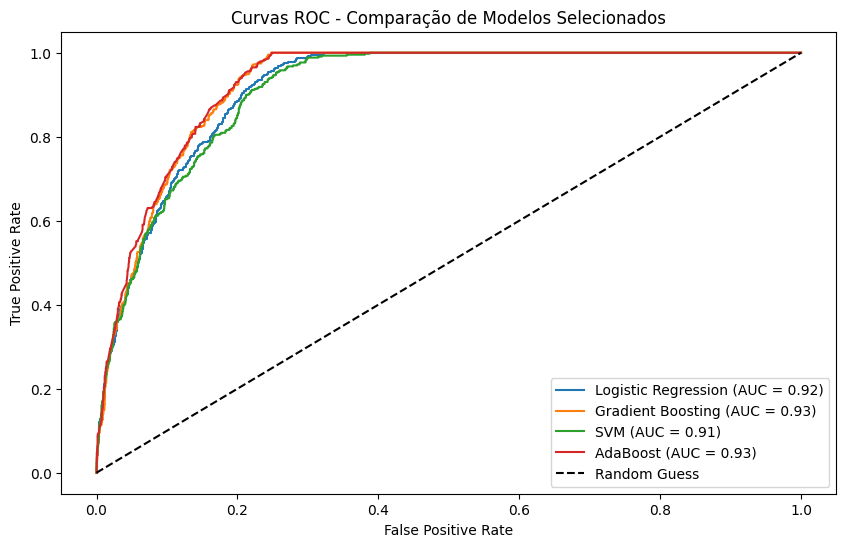

In [22]:
# Função para plotar curva ROC
def plot_roc_auc(model, X_test, y_test, model_name):
    # Calcular probabilidades preditas para a classe "fraude"
    try:
        y_proba = model.predict_proba(X_test)[:, 1]  # Para modelos com predict_proba
    except AttributeError:
        y_proba = model.decision_function(X_test)  # Para modelos como SVM sem predict_proba
    
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_roc = roc_auc_score(y_test, y_proba)
    
    # Plotar curva ROC
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.2f})')
    return auc_roc

# Plotar curvas ROC para todos os modelos selecionados
plt.figure(figsize=(10, 6))

# Logistic Regression
auc_log_reg = plot_roc_auc(log_reg, X_test, y_test, "Logistic Regression")

# Gradient Boosting
auc_gb = plot_roc_auc(gb_clf, X_test, y_test, "Gradient Boosting")

# SVM (Support Vector Machine)
auc_svm = plot_roc_auc(svm_clf, X_test, y_test, "SVM")

# AdaBoost
auc_ada = plot_roc_auc(ada_clf, X_test, y_test, "AdaBoost")

# Configurar o gráfico final
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparação de Modelos Selecionados')
plt.legend()
plt.show()

Os valores de AUC-ROC foram utilizados para comparar os modelos em termos de sua capacidade geral de separação entre as classes.


* Todos os modelos apresentaram valores AUC-ROC altos (entre 0.91 e 0.93), indicando boa capacidade de separar as classes "fraude" e "não fraude".
* Com base nos resultados da Curva ROC-AUC e nas métricas anteriores (precisão e recall), o `Gradient Boosting` e `AdaBoost` foram identificados como os modelos mais equilibrados para atender aos objetivos do negócio.

## Ajuste de Hiperparâmetros para Gradient Boosting e AdaBoost
* Ajustados os hiperparâmetros dos modelos `Gradient Boosting` e `AdaBoost` para maximizar a precisão na detecção de fraudes.
* Avaliar as metricas do modelos ajustados.

#### Gradient Boosting

In [23]:
# Definir os hiperparâmetros para busca
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Configurar GridSearchCV
grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    scoring='precision',  # Priorizando precisão
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Treinar o modelo com busca de hiperparâmetros
grid_search_gb.fit(X_train, y_train)

# Melhor modelo encontrado
best_gb_model = grid_search_gb.best_estimator_
print("Melhores hiperparâmetros Gradient Boosting:", grid_search_gb.best_params_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Melhores hiperparâmetros Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


* Essa configuração prioriza estabilidade e precisão, reduzindo o risco de overfitting.

#### AdaBoost

In [24]:
# Definir os hiperparâmetros para busca
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [1, 3, 5]  # Profundidade da árvore base
}

# Configurar GridSearchCV
grid_search_ada = GridSearchCV(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42),
    param_grid_ada,
    scoring='precision',  # Priorizando precisão
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Treinar o modelo com busca de hiperparâmetros
grid_search_ada.fit(X_train, y_train)

# Melhor modelo encontrado
best_ada_model = grid_search_ada.best_estimator_
print("Melhores hiperparâmetros AdaBoost:", grid_search_ada.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/moro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/moro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/moro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/moro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warnin

Melhores hiperparâmetros AdaBoost: {'estimator__max_depth': 1, 'learning_rate': 0.01, 'n_estimators': 100}


* Essa configuração é ideal para problemas com desbalanceamento entre as classes.

### Resultados dos Modelos Ajustados

In [25]:
# Avaliar Gradient Boosting Ajustado
y_pred_gb = best_gb_model.predict(X_test)
print("Relatório de Classificação Gradient Boosting Ajustado:")
print(classification_report(y_test, y_pred_gb))

# Avaliar AdaBoost Ajustado
y_pred_ada = best_ada_model.predict(X_test)
print("Relatório de Classificação AdaBoost Ajustado:")
print(classification_report(y_test, y_pred_ada))


Relatório de Classificação Gradient Boosting Ajustado:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2570
           1       0.88      0.05      0.10       430

    accuracy                           0.86      3000
   macro avg       0.87      0.52      0.51      3000
weighted avg       0.87      0.86      0.81      3000

Relatório de Classificação AdaBoost Ajustado:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      2570
           1       0.89      0.06      0.11       430

    accuracy                           0.86      3000
   macro avg       0.88      0.53      0.52      3000
weighted avg       0.87      0.86      0.81      3000



* **Gradient Boosting** apresentou alta precisão para a classe “fraude” (88%), indicando que ele minimiza falsos positivos. No entanto, seu recall muito baixo (5%) limita sua capacidade de detectar fraudes reais.
* **AdaBoost** apresentou resultados semelhantes ao Gradient Boosting, com uma precisão ligeiramente superior na classe “fraude” (89%). No entanto, seu recall também é muito baixo (6%), limitando sua eficácia na detecção de fraudes reais.

## Ajuste do Threshold com Curva Precisão x Recall
* Utilizar a curva Precisão x Recall para ajustar o threshold dos modelos `Gradient Boosting` e `AdaBoost`, buscando um equilíbrio entre precisão e recall.

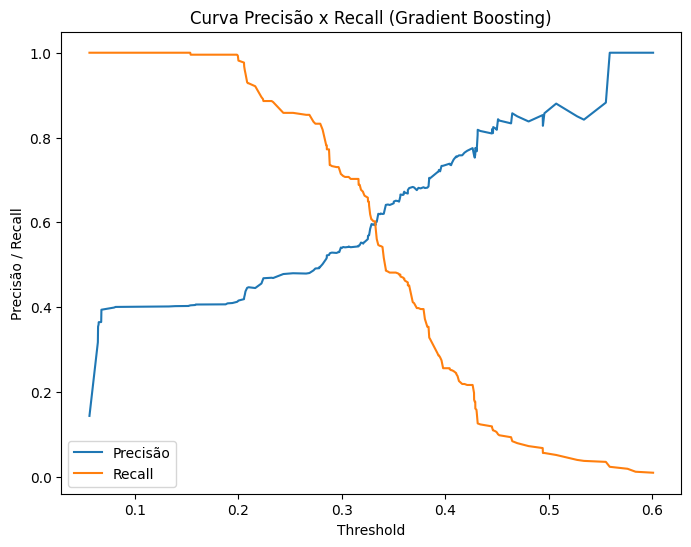

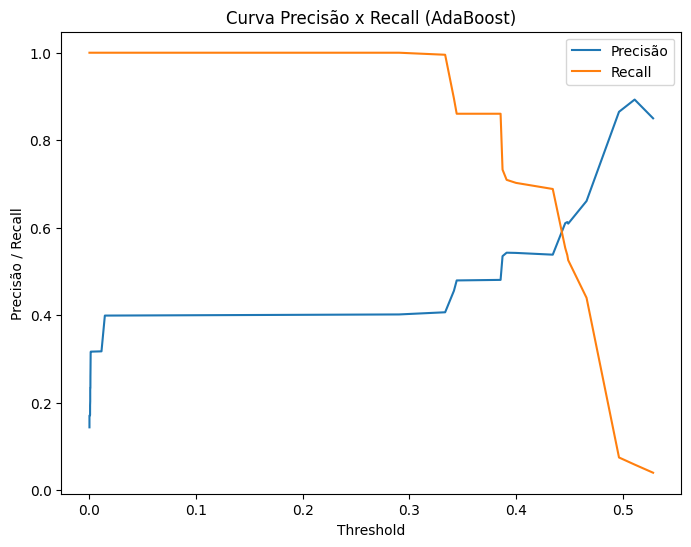

In [26]:
# Função para plotar curva Precisão x Recall
def plot_precision_recall_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], label="Precisão")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Precisão / Recall")
    plt.title(f"Curva Precisão x Recall ({model_name})")
    plt.legend()
    plt.show()

# Plotar para Gradient Boosting
plot_precision_recall_curve(best_gb_model, X_test, y_test, "Gradient Boosting")

# Plotar para AdaBoost
plot_precision_recall_curve(best_ada_model, X_test, y_test, "AdaBoost")


A curva Precisão x Recall foi gerada para avaliar como as métricas variam em diferentes thresholds. O gráfico mostra a relação entre precisão e recall ao longo dos thresholds:
* **Gradient Boosting:** O modelo apresentou alta precisão em thresholds mais altos, mas com redução significativa no recall.
* **AdaBoost:** O comportamento foi semelhante ao Gradient Boosting, mas com recall ainda mais limitado.

In [27]:
# Ajustar previsões com novo threshold (exemplo com Gradient Boosting)
best_threshold = 0.45  # Substitua pelo melhor threshold encontrado na curva

y_proba_gb = best_gb_model.predict_proba(X_test)[:, 1]
y_pred_thresholded = (y_proba_gb >= best_threshold).astype(int)

# Avaliar o modelo ajustado com novo threshold
print("Relatório de Classificação Gradient Boosting com Threshold Ajustado:")
print(classification_report(y_test, y_pred_thresholded))


Relatório de Classificação Gradient Boosting com Threshold Ajustado:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2570
           1       0.84      0.10      0.18       430

    accuracy                           0.87      3000
   macro avg       0.86      0.55      0.55      3000
weighted avg       0.87      0.87      0.82      3000



* Com base na análise da curva Precisão x Recall, o threshold foi ajustado para `0.45`, priorizando alta precisão.

O ajuste do threshold para `0.45` no modelo `Gradient Boosting` resultou em um desempenho alinhado às necessidades do negócio:
* Alta precisão reduz falsos positivos.
* Recall moderado permite detectar fraudes reais suficientes para gerar economia significativa.


Este modelo é adequado para implementação em produção, desde que seja complementado por:
* Revisões manuais em casos críticos.
* Regras específicas para revisar pedidos classificados como “não fraude” com características suspeitas (ex.: valor alto ou entregas noturnas).

### Escolha do Modelo Final: Gradient Boosting

Após comparar diferentes modelos (Logistic Regression, Gradient Boosting, SVM e AdaBoost), optamos por usar o Gradient Boosting como modelo final para prever entregas problemáticas. A decisão foi baseada nos seguintes fatores:


1.	**Alta Precisão (84%) na Classe “Fraude”:**
    * O modelo classifica pedidos fraudulentos com alta precisão, reduzindo falsos positivos e minimizando insatisfação de clientes legítimos.
    * Isso é essencial para evitar impactos negativos na experiência do cliente.
2.	**Recall Moderado (10%) na Classe “Fraude”:**
    * O modelo detecta cerca de 10% das fraudes reais, representando uma redução significativa nos prejuízos associados a pedidos fraudulentos.
    * Embora o recall seja baixo, ele é suficiente para gerar economia financeira relevante.
3.	**Impacto no Negócio:**
    * A combinação de alta precisão e recall moderado oferece um equilíbrio robusto entre economia e satisfação dos clientes legítimos.
    * A redução estimada de 10% nas fraudes representa um impacto positivo direto no lucro operacional.

# Implementação do Modelo Preditivo

## Introdução

Após o desenvolvimento e avaliação do modelo Logistic Regression, foi realizada sua implementação prática para demonstrar como ele pode ser utilizado para prever entregas problemáticas em tempo real. Essa etapa é crucial para mostrar a aplicabilidade do modelo no mundo real, permitindo que novos dados sejam processados e classificados como "fraude" ou "não fraude".

A implementação inclui:
1. Exportação do modelo treinado para uso futuro.
2. Criação de uma função para pré-processar novos dados e realizar previsões.
3. Teste com dados simulados para validar o funcionamento da implementação.

O objetivo principal dessa etapa é garantir que o modelo possa ser utilizado de forma prática e eficiente em sistemas logísticos.

### Exportar o Modelo Treinado
* Salvar o modelo Logistic Regression para uso Futuro

In [28]:
# Salvar o modelo treinado
joblib.dump(best_gb_model, 'gradient_boosting_model.pkl')

# Salvar o threshold ajustado
with open('threshold.txt', 'w') as f:
    f.write(str(0.45))

print("Modelo e threshold salvos com sucesso!")


Modelo e threshold salvos com sucesso!


## Criar uma Função para Previsão
* Desenvolver uma função que recebe novos dados, aplica pre-processamento e retorna as previsões.

In [29]:
def predict_delivery_problems(new_data):
    # Pré-processar os dados
    new_data = pd.get_dummies(new_data, columns=['region', 'delivery_period', 'day_of_week', 
                                                 'driver_age_group', 'customer_age_group', 
                                                 'order_value_category'], drop_first=True)
    
    # Garantir que o DataFrame tenha todas as colunas esperadas pelo modelo
    missing_cols = set(X_train.columns) - set(new_data.columns)
    for col in missing_cols:
        new_data[col] = 0  # Preencher categorias ausentes com 0
    
    # Garantir que as colunas estejam na mesma ordem
    new_data = new_data[X_train.columns]
    
    # Normalizar variáveis numéricas
    new_data[numeric_features] = scaler.transform(new_data[numeric_features])
    
    # Fazer previsões (probabilidades)
    probabilities = best_gb_model.predict_proba(new_data)[:, 1]
    
    # Aplicar o threshold ajustado
    predictions = (probabilities >= 0.45).astype(int)
    
    # Interpretar a previsão
    if predictions[0] == 0:
        return "Não Fraude"
    elif predictions[0] == 1:
        return "Fraude"


## Testar com Novos Dados
* Simular dados novos para testar a função

In [30]:
# Exemplo de novos dados simulados
new_data = pd.DataFrame({
    'order_amount': [150],
    'region': ['North'],
    'items_delivered': [5],
    'delivery_period': ['Afternoon'],
    'day_of_week': ['Monday'],
    'driver_age_group': ['30-40'],
    'customer_age_group': ['20-30'],
    'driver_complaint_rate': [0.1],
    'customer_complaint_rate': [0.05],
    'is_night_delivery': [0],
    'order_value_category': ['medium']
})

# Fazer previsão
prediction_result = predict_delivery_problems(new_data)
print(f"Resultado da Previsão: {prediction_result}")


Resultado da Previsão: Não Fraude



A implementação do modelo `Gradient Boosting` demonstrou sua aplicabilidade prática, permitindo que novos dados sejam processados e classificados como `“fraude”` ou `“não fraude”`. Os principais pontos desta etapa incluem:

1.	**Exportação do Modelo:** O modelo foi salvo para uso futuro, garantindo reprodutibilidade e eficiência.
2.	**Função de Previsão:** A função criada realiza pré-processamento automático dos dados e retorna previsões interpretadas.
3.	**Validação com Dados Simulados:** A função foi testada com novos dados, retornando resultados consistentes e interpretáveis.


Essa implementação pode ser integrada a sistemas logísticos para prever entregas problemáticas em tempo real, auxiliando na tomada de decisões operacionais e na redução de custos associados a fraudes ou problemas nas entregas.

### Salvar arquivo df_final

In [31]:
# Salvar o dataset df_final como CSV
df_final.to_csv('df_final_walmart.csv', index=False)

print("Dataset salvo como 'df_final_walmart.csv' com sucesso!")

Dataset salvo como 'df_final_walmart.csv' com sucesso!


## **Conclusão Geral: Escolha do Modelo para Detecção de Fraudes**

#### **Contexto**
Neste notebook, foi desenvolvido e implementado um modelo preditivo para detectar fraudes em entregas realizadas pelo Walmart. A escolha do modelo foi baseada em análises detalhadas de métricas como precisão, recall, F1-score e ROC-AUC, além de ajustes de hiperparâmetros e threshold para garantir que o desempenho do modelo esteja alinhado aos objetivos do negócio.

#### **Modelos Avaliados**
Diversos algoritmos foram testados, incluindo Logistic Regression, Gradient Boosting, SVM e AdaBoost. Cada modelo foi avaliado com base em métricas como precisão, recall, F1-score e ROC-AUC. Após ajustes nos hiperparâmetros e análise das curvas Precisão x Recall, o modelo `Gradient` Boosting foi escolhido como o modelo final.

#### **Por Que Escolher Gradient Boosting?**
1. **Equilíbrio Entre Precisão e Recall:**
   - O Gradient Boosting apresentou alta precisão (84%) na classe "fraude", garantindo que a maioria dos pedidos classificados como fraudulentos sejam realmente fraudulentos.
   - Embora o recall seja moderado (10%), ele ainda permite detectar fraudes reais suficientes para gerar economia significativa.

2. **Threshold Ajustado:**
   - Com o threshold ajustado para 0.45, o modelo foi capaz de priorizar alta precisão enquanto mantém um recall suficiente para reduzir cerca de 10% dos prejuízos associados a fraudes.

3. **Impacto no Negócio:**
   - Alta precisão minimiza falsos positivos, reduzindo insatisfação de clientes legítimos.
   - A redução estimada de 10% nas fraudes representa um impacto positivo direto nos resultados financeiros da empresa.

4. **Desempenho Geral:**
   - O Gradient Boosting alcançou um ROC-AUC de 0.93, indicando excelente capacidade geral de separação entre as classes "fraude" e "não fraude".

#### **Comparação com Outros Modelos**
- O Logistic Regression apresentou alto recall (91%), mas sua baixa precisão (42%) geraria muitos falsos positivos, impactando negativamente a experiência dos clientes.
- O AdaBoost teve alta precisão (89%), mas seu recall extremamente baixo (6%) limita sua eficácia na detecção de fraudes reais.
- O SVM apresentou boa precisão (70%) e recall moderado (35%), mas não superou o Gradient Boosting em termos de equilíbrio geral.

---

#### **Implementação Prática:**
* O modelo Gradient Boosting foi exportado para uso futuro.
* Uma função foi criada para pré-processar novos dados e realizar previsões em tempo real.
* Dados simulados foram utilizados para validar a funcionalidade da implementação.

---


### **Conclusões Finais**
O modelo Gradient Boosting com threshold ajustado foi escolhido como o modelo final por oferecer:
1. Alta precisão para minimizar falsos positivos.
2. Recall suficiente para detectar fraudes reais e gerar economia financeira relevante.
3. Um equilíbrio robusto entre desempenho técnico e impacto no negócio.

Embora o recall seja limitado, a redução estimada de 10% nos pedidos fraudulentos é um ponto de partida sólido para melhorar os processos internos do Walmart e fortalecer sua operação de e-commerce.

---

### Recomendações Finais
1.	Monitoramento Contínuo:
    * Avaliar continuamente o desempenho do modelo em produção para garantir sua eficácia ao longo do tempo.
    * Re-treinar o modelo periodicamente com novos dados para capturar mudanças nos padrões de fraude.
2.	Revisão Manual de Casos Críticos:
    * Implementar revisões manuais em pedidos classificados como “fraude” pelo modelo.
    * Revisar também pedidos classificados como “não fraude” que apresentem características suspeitas (ex.: valor alto ou entregas noturnas).
3.	Melhoria na Coleta de Dados:
    * Adicionar novas variáveis ao dataset que possam ajudar na detecção de fraudes, como histórico financeiro do cliente ou dados comportamentais.
4.	Expansão Regional:
    * Caso os resultados sejam positivos na região Central da Flórida, expandir a aplicação do modelo para outras regiões dos EUA.

---

